# Import library

In [1]:
!pip install PySastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
print(tf.__version__)

     |████████████████████████████████| 215kB 29.4MB/s 
2.4.1


# Function to stem and stopword removal

In [2]:
stop = []
with  open('/content/drive/MyDrive/Bangkit/stopword.txt') as f:
    csv_file = csv.reader(f)
    for word in csv_file:
        stop.append(word[0])

In [3]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [4]:
dictionary = ArrayDictionary(stop)
stopword = StopWordRemover(dictionary)

# Preprocess Dataset

## Stem and Stopword removal

In [5]:
dataset = pd.read_csv(r'/content/drive/MyDrive/Bangkit/news.csv', sep=";")
dataset['berita_preprocessed'] = dataset.apply(lambda x:  stopword.remove(stemmer.stem(x['berita'])), axis=1)
dataset['class'] = dataset['tagging'].replace({'Valid':1, 'Hoax':0})
dataset.drop_duplicates(subset='berita_preprocessed', inplace=True)
dataset.drop(columns=['berita', 'tagging'], inplace=True)
dataset
# dataset.to_csv(path_or_buf='/content/preprocessed.csv',index=False)

,berita_preprocessed,class
0,jakarta jejaring sosial edar informasi lele ik...,1
1,isu ikan lele kandung sel kanker jejaring soci...,1
2,nikmat kuliner bahan dasar ikan lele berita su...,1
3,ikan lele rupa salah makan favorit indonesia h...,1
4,ikan lele rupa bahan makan populer indonesia s...,1
...,...,...
593,kabar edar putar rencana gaji presiden wakil p...,1
594,kepala biro pers media informasi sekretariat p...,1
597,edar berita nyata gaji presiden wakil presiden...,1
598,rancang atur perintah rpp gaji tunjang pegawai...,1


## Split dataset to train, val, and test set (80, 10, 10)

In [6]:
trainset = dataset.sample(frac=0.8).reset_index(drop=True)
print(trainset)

                                   berita_preprocessed  class
0    buruk netizen jangkit nama latah malas kroscek...      1
1    iphone 6 iphone 6 plus kabar mudah lengkung be...      1
2    gaji presiden ri drastis capai rp 500 juta rp ...      0
3    tugas resnarkoba polres buleleng dinas industr...      0
4    pesan beranta waspada hadap sikat gigi bahan b...      1
..                                                 ...    ...
468  perintah gemas sikap youtube facebook twitter ...      0
469  aple buka suara kena iphone 6 lengkung ramai b...      1
470  badan awas obat makan bpom nyata permen merk p...      1
471  edar kabar jagat media sosial rusuh rumah taha...      0
472  lele rupa ikan habitat air tawar ikan ternak l...      0

[473 rows x 2 columns]


In [7]:
dataset = dataset.merge(trainset, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only'].drop(columns=['_merge'])
valset = dataset.sample(frac=0.5).reset_index(drop=True)
print(valset)

                                  berita_preprocessed  class
0   konsulat jenderal republik indonesia davao cit...      1
1   blog video youtube ikan lele kadung sel kanker...      1
2   apple cetak rekor jual 10 juta unit minggu lun...      1
3   ricuh rumah tahan markas korps brimob kelapa d...      1
4   davao - philipina konsulat jenderal ri davao o...      0
5   indeksnews kabar facebook tutup blokir tanggal...      1
6   berita pokemon produk yahudi trending topik fa...      0
7   konsulat jenderal republik indonesia davao fil...      1
8   gubernur dki jakarta anies baswedan sayang aja...      1
9   kepala terang kabagpenum polri kombes pol mart...      1
10  sebar buah informasi resah masyarakat isu bulu...      1
11  ribut kabar rutan teroris korps brimob cabang ...      1
12  rusuh mako brimob kelapa depok jumat 10 11 mal...      1
13  demam game pokemon go nyata tarik perhati kala...      1
14  imbas razia polisi pamong praja satpol pp pemk...      1
15  permen dot edar masy

In [8]:
testset = dataset.merge(valset, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only'].drop(columns=['_merge']).reset_index(drop=True)
print(testset)

                                  berita_preprocessed  class
0   isu ikan lele kandung sel kanker jejaring soci...      1
1   lele ikan kotor iya lele rupa salah menu makan...      0
2   makan gari gurih goda lidah ikan lele dibudida...      0
3   tusuk jarum sembuh sakit stroke edar informasi...      0
4   stroke sehat bahaya rupa bunuh nomor 3 dunia t...      0
5   mitos kena cegah sakit stroke salah tusuk jaru...      0
6   tolong tusuk jarum derita stroke curiga dengar...      0
7   apple resmi nyata tanggap keluh iphone 6 plus ...      1
8   liputan6 com california - keluh iphone 6 plus ...      1
9   rilis jual resmi iphone 6 iphone 6 plus keluh ...      0
10  kabar konsumen niat beli iphone 6 plus rilis p...      0
11  sungguh oknum konsultan jenderal republik indo...      0
12  jakarta - anggota komunitas reyog ponorogo krp...      1
13  jakarta news - juru bicara menteri negeri arrm...      0
14  konjen ri davao city eko hartono bakar perangk...      1
15  jakarta aksi 212 sel

# Tokenizer the dataset

## Initialize variable for tokenizer

In [9]:
vocab_size = 10000
embedding_dim = 32
max_length = 4610
trunc_type='post'
oov_tok = "<OOV>"

## Train Set

In [10]:
trainset_x = trainset['berita_preprocessed'].to_list()
trainset_y = trainset['class'].to_numpy()
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(trainset_x)
trainset_x_seq = tokenizer.texts_to_sequences(trainset_x)
trainset_padded = pad_sequences(trainset_x_seq, maxlen=max_length, truncating=trunc_type)
print(trainset_padded)

[[   0    0    0 ...   95    7 3072]
 [   0    0    0 ...   59  240  766]
 [   0    0    0 ... 1165 2011  295]
 ...
 [   0    0    0 ... 2908  382 2497]
 [   0    0    0 ...   99   17   29]
 [   0    0    0 ... 3529 2897  585]]


## Validation Set

In [11]:
valset_x = valset['berita_preprocessed'].to_list()
valset_y = valset['class'].to_numpy()
valset_x_seq = tokenizer.texts_to_sequences(valset_x)
valset_padded = pad_sequences(valset_x_seq, maxlen=max_length, truncating=trunc_type)
print(valset_padded)

[[   0    0    0 ...   33   77  432]
 [   0    0    0 ...    1    7 6193]
 [   0    0    0 ...   74   47 2250]
 ...
 [   0    0    0 ...    1  157  337]
 [   0    0    0 ... 2705 1729    1]
 [   0    0    0 ...  129  155 2444]]


## Test Set

In [12]:
testset_x = testset['berita_preprocessed'].to_list()
testset_y = testset['class'].to_numpy()
testset_x_seq = tokenizer.texts_to_sequences(testset_x)
testset_padded = pad_sequences(testset_x_seq, maxlen=max_length, truncating=trunc_type)
print(testset_padded)

[[   0    0    0 ...  585  597  878]
 [   0    0    0 ...    3   85  156]
 [   0    0    0 ...  218   62   61]
 ...
 [   0    0    0 ... 2009   30   52]
 [   0    0    0 ...  401  504 1846]
 [   0    0    0 ...   21   70 1147]]


# Deep Learning

## Model

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4610, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 338,753
Trainable params: 338,753
Non-trainable params: 0
_________________________________________________________________


## Train

In [16]:
num_epochs = 20
history = model.fit(trainset_padded, trainset_y, epochs=num_epochs, validation_data=(valset_padded, valset_y))

Epoch 1/50
15/15 [==============================] - 4s 244ms/step - loss: 0.0610 - accuracy: 0.9725 - val_loss: 0.4720 - val_accuracy: 0.8814
Epoch 2/50
15/15 [==============================] - 4s 239ms/step - loss: 0.0744 - accuracy: 0.9641 - val_loss: 0.4594 - val_accuracy: 0.8644
Epoch 3/50
15/15 [==============================] - 4s 240ms/step - loss: 0.0507 - accuracy: 0.9767 - val_loss: 0.5048 - val_accuracy: 0.8814
Epoch 4/50
15/15 [==============================] - 4s 238ms/step - loss: 0.0475 - accuracy: 0.9746 - val_loss: 0.4838 - val_accuracy: 0.8814
Epoch 5/50
15/15 [==============================] - 4s 240ms/step - loss: 0.0523 - accuracy: 0.9746 - val_loss: 0.5382 - val_accuracy: 0.8644
Epoch 6/50
15/15 [==============================] - 4s 239ms/step - loss: 0.0420 - accuracy: 0.9810 - val_loss: 0.5200 - val_accuracy: 0.8814
Epoch 7/50
15/15 [==============================] - 4s 242ms/step - loss: 0.0477 - accuracy: 0.9725 - val_loss: 0.6009 - val_accuracy: 0.8644
Epoch 

## Graph

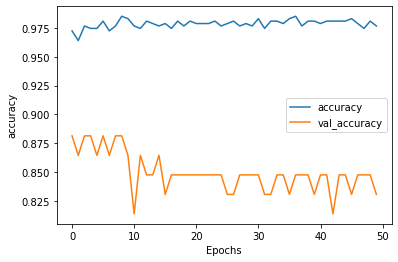

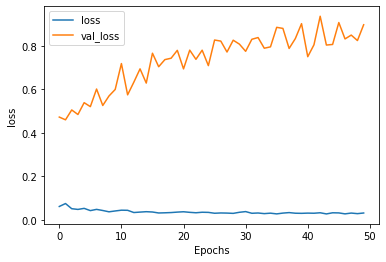

In [17]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')